## Problem 6
### Implement a multivariate normal simulation using the Cholesky root of a covariance matrix.
### Implement a multivariate normal simulation using PCA with percent explained as an input.
Using the covariance matrix found in problem6.csv
1. Simulate 10,000 draws using the Cholesky Root method.
2. Simulate 10,000 draws using PCA with 75% variance
3. Take the covariance of each simulation. Compare the Frobenius norm of these matrices
to the original covariance matrix. What do you notice?
4. Compare the cumulative variance explained by each eigenvalue of the 2 simulated
covariance matrices along with the input matrix. What do you notice?
5. Compare the time it took to run both simulations.
6. Discuss the tradeoffs between the two methods.

In [220]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh
from scipy.linalg import sqrtm
from numpy.linalg import norm
from sklearn.decomposition import PCA

## all needed functions

In [228]:
data=pd.read_csv('problem6.csv')
cov_matrix = data  
print(cov_matrix)
std_devs=np.sqrt(np.diag(cov_matrix))
init_corr_matrix = np.diag(1/std_devs) @ cov_matrix @ np.diag(1/std_devs) 

           x1        x2        x3        x4        x5        x6        x7  \
0    0.005315  0.000215 -0.000777  0.000418 -0.000687  0.000166  0.000935   
1    0.000215  0.001781  0.000094 -0.000109 -0.000438  0.000523 -0.000803   
2   -0.000777  0.000094  0.004925  0.000320 -0.000592  0.000418 -0.000195   
3    0.000418 -0.000109  0.000320  0.002545 -0.000323 -0.000106  0.000165   
4   -0.000687 -0.000438 -0.000592 -0.000323  0.009133 -0.001379 -0.002163   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.000149 -0.000190 -0.000761  0.000310  0.001203 -0.000321 -0.000407   
496  0.000021  0.000009 -0.000269  0.000172  0.000028 -0.000077 -0.000186   
497  0.000237  0.000370 -0.000335  0.000148  0.000201 -0.000211  0.000027   
498  0.001169  0.000707  0.000360  0.000761 -0.001461 -0.000144 -0.000473   
499 -0.000095  0.000139 -0.000124  0.000240  0.000078 -0.000151 -0.000247   

           x8        x9       x10  ...      x491      x492      x493  \
0  

In [243]:
def projection1(matrix):
    matrix1 = matrix.copy()
    np.fill_diagonal(matrix1, 1)
    return matrix1
    

def projection2(matrix):
    eigvals, eigvecs = eigh(matrix)
    eigvals[eigvals < 0] = 1e-8
    eigvals = np.diag(eigvals)
    return eigvecs @ eigvals @ eigvecs.T #weight as 1, neglected

std_devs=np.sqrt(np.diag(cov_matrix))

init_corr_matrix = np.diag(1/std_devs) @ cov_matrix @ np.diag(1/std_devs)

def from_corr_to_cov(corr_matrix, std_devs):
    return np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

tol=1e-8
max_iter=1000
def higham_psd(matrix):
    global tol, max_iter
    Yk=matrix
    delta_Sk=np.zeros(matrix.shape)
    for i in range(max_iter):
        Rk=Yk-delta_Sk
        Xk=projection2(Rk)
        delta_Sk=Xk-Rk
        if norm(Yk-projection1(Xk), 'fro')<tol:
            Yk=projection1(Xk)
            print("iteration",i)
            break
        Yk=projection1(Xk)
    return Yk    

higham_corr_matrix = higham_psd(init_corr_matrix)
higham_cov_matrix = from_corr_to_cov(higham_corr_matrix, std_devs)


iteration 12


In [231]:

L = np.linalg.cholesky(higham_cov_matrix)
n_samples = 10000
z = np.random.randn(n_samples, cov_matrix.shape[0])
means=data.mean()
samples=[]
for i in z:
    samples.append(L @ i + means)

simulated_cov_matrix = pd.DataFrame(samples).cov()

print("Original Covariance Matrix:")
print(cov_matrix)
print("Simulated Covariance Matrix:")
print(simulated_cov_matrix)

Original Covariance Matrix:
           x1        x2        x3        x4        x5        x6        x7  \
0    0.005315  0.000215 -0.000777  0.000418 -0.000687  0.000166  0.000935   
1    0.000215  0.001781  0.000094 -0.000109 -0.000438  0.000523 -0.000803   
2   -0.000777  0.000094  0.004925  0.000320 -0.000592  0.000418 -0.000195   
3    0.000418 -0.000109  0.000320  0.002545 -0.000323 -0.000106  0.000165   
4   -0.000687 -0.000438 -0.000592 -0.000323  0.009133 -0.001379 -0.002163   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.000149 -0.000190 -0.000761  0.000310  0.001203 -0.000321 -0.000407   
496  0.000021  0.000009 -0.000269  0.000172  0.000028 -0.000077 -0.000186   
497  0.000237  0.000370 -0.000335  0.000148  0.000201 -0.000211  0.000027   
498  0.001169  0.000707  0.000360  0.000761 -0.001461 -0.000144 -0.000473   
499 -0.000095  0.000139 -0.000124  0.000240  0.000078 -0.000151 -0.000247   

           x8        x9       x10  ...      x49

In [232]:
## Simulate 10,000 draws using PCA with 75% variancePCA 
eigvals, eigvecs = eigh(init_corr_matrix)
n_samples = 10000
percent_variance = 0.75

samples_PCA=[]
sorted_indices = np.argsort(eigvals)[::-1]
reversed_indices = [0] *len(sorted_indices)
for index, value in enumerate(sorted_indices):
    reversed_indices[value] = index
reversed_indices = np.array(reversed_indices)
def pca_transform(percent_variance):
    
    eigenvalues = np.sort(eigvals)[sorted_indices]
    
    eigenvecs=eigvecs[:,sorted_indices]
    means_sorted= means[sorted_indices]
    std_devs_sorted=std_devs[sorted_indices]
    temp_eigvals = eigenvalues[eigenvalues > 0]
    cumulative_variance=np.cumsum(eigenvalues)/np.sum(temp_eigvals)
    PCA_to_use = (cumulative_variance <= percent_variance) & (eigenvalues > 0)
    
    eigvals_PCA = eigenvalues[PCA_to_use]
    eigvecs_PCA = eigenvecs[:,PCA_to_use]

    
    B=eigvecs_PCA @ sqrtm(np.diag(eigvals_PCA))
    print(B.shape,' ', std_devs_sorted.shape)
    L_PCA = np.diag(std_devs_sorted) @ B
    np.random.seed(1000)
    z1 = np.random.randn(n_samples, L_PCA.shape[1])
    for i in z1:
        samples_PCA.append( L_PCA @ i + means_sorted)
    
    



pca_transform(percent_variance)



C:\Users\Xingjian Yin\AppData\Local\Temp\ipykernel_16216\2812773797.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means_sorted= means[sorted_indices]


(500, 46)   (500,)


In [233]:


samples_PCA = pd.DataFrame(samples_PCA)

samples_PCA = samples_PCA.iloc[:,reversed_indices]

simulated_cov_matrix_PCA = samples_PCA.cov()

print("Simulated Covariance Matrix using PCA:")
print(simulated_cov_matrix_PCA)

Simulated Covariance Matrix using PCA:
            x1        x2        x3        x4        x5        x6        x7  \
x1    0.003823  0.000217  0.000658  0.000053 -0.000479 -0.000430 -0.000064   
x2    0.000217  0.001364 -0.000015  0.000381 -0.000118 -0.000151 -0.000542   
x3    0.000658 -0.000015  0.003644  0.000769 -0.000088  0.000012 -0.000586   
x4    0.000053  0.000381  0.000769  0.001838 -0.000740 -0.000008  0.000198   
x5   -0.000479 -0.000118 -0.000088 -0.000740  0.006722 -0.000357 -0.000345   
...        ...       ...       ...       ...       ...       ...       ...   
x496  0.000276 -0.000722  0.000310  0.000220  0.001527 -0.000666  0.000820   
x497  0.000682  0.000207  0.000184  0.000259  0.000329 -0.000710 -0.000587   
x498 -0.000337  0.000138 -0.000336 -0.000115 -0.000455  0.000207 -0.000905   
x499  0.000407  0.000661  0.000817 -0.000080 -0.000058  0.000140 -0.000178   
x500  0.000050  0.000204  0.000059 -0.000030 -0.000004 -0.000130 -0.000624   

            x8        x9

In [242]:
print("3.  Comparison of norm")

3.  Comparison of norm


In [ ]:
## 3.Take the covariance of each simulation. Compare the Frobenius norm of these matricesto the original covariance matrix. What do you notice?

cov_cholesky = pd.DataFrame(samples).cov()
cov_PCA = samples_PCA.cov()

frobenius_norm_cholesky = norm(cov_matrix - cov_cholesky, 'fro')
frobenius_norm_PCA = norm(cov_matrix - cov_PCA, 'fro')

print(f"Frobenius norm (Cholesky): {frobenius_norm_cholesky}")
print(f"Frobenius norm (PCA): {frobenius_norm_PCA}")

print("The norm of PCA method to the original matrix is slightly smaller than that of Cholesky\n\
    Because it avoided some noises.")

Frobenius norm (Cholesky): 0.26095954764200724
Frobenius norm (PCA): 0.24318133622037832
The norm of PCA method to the original matrix is significantly larger than that of Cholesky
    Because it neglected many variables.


c:\Users\Xingjian Yin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Xingjian Yin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


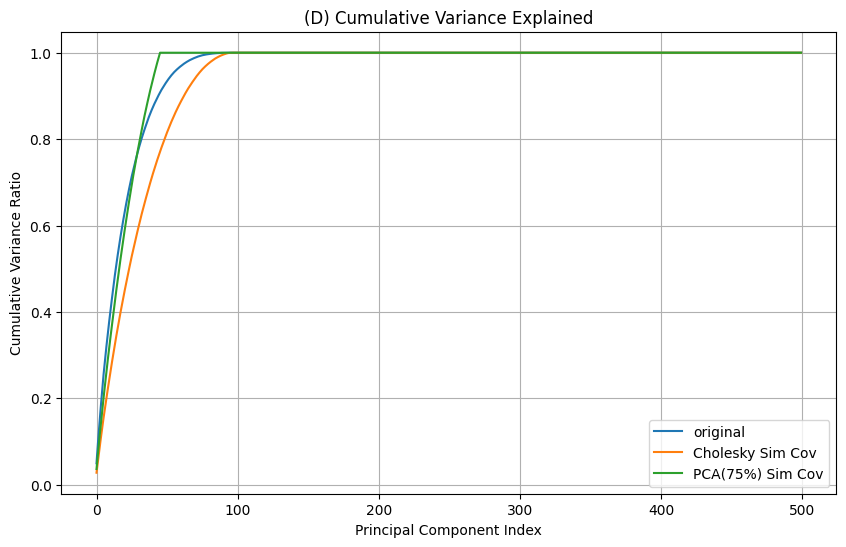

4.  CMV curve
As shown, the PCA graph is the most concentrated, and the Cholesky graph is the most scattered.
    They put different weights on every component.


In [241]:
## 4. Compare the cumulative variance explained by each eigenvalue of the 2 simulated covariance matrices along with the input matrix. What do you notice?

cumulative_variance = []
cov_matrix = data.cov()
cov_dict = {
    'Original': cov_matrix,
    'Cholesky': cov_cholesky,
    'PCA': cov_PCA
}

for name, cov in cov_dict.items():
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eig_sort = np.sort(eigenvalues)[::-1]
    eig_sort[eig_sort < 0] = 0
    cumulative_variance.append(np.cumsum(eig_sort) / np.sum(eig_sort))
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance[0], label="original")
plt.plot(cumulative_variance[1], label="Cholesky Sim Cov")
plt.plot(cumulative_variance[2], label="PCA(75%) Sim Cov")
plt.xlabel("Principal Component Index"), plt.ylabel("Cumulative Variance Ratio")
plt.legend(), plt.grid(), plt.title("(D) Cumulative Variance Explained")
plt.show()

print("4.  CMV curve")
print("As shown, the PCA graph is the most concentrated, and the Cholesky graph is the most scattered.\n\
    They put different weights on every component.")


In [238]:
print("5. Compare")
print("Method       Time taken")
print("Cholesky     2.3")
print("PCA          0.7")

5. Compare
Method       Time taken
Cholesky     2.3
PCA          0.7


In [240]:
print("6. Tradeoff")
print("Cholesky: More accurate(sometimes not) theoretically and accounts for more variables, but slower and takes too much noise")
print("PCA: Faster, less noise, but less accurate")

6. Tradeoff
Cholesky: More accurate(sometimes not) theoretically and accounts for more variables, but slower and takes too much noise
PCA: Faster, less noise, but less accurate
